# STL10 PCA and GMM Experiment
#### by Pio Lauren T. Mendoza

In this notebook the Principal Component Analysis (PCA) and Gaussian Mixture Models will be built from scratch by only using pure python and numpy. Their performance will be evaluated under various conditions.

### Importing Modules

In [1]:
from numpy.random import default_rng
from PIL import Image
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np

rng = default_rng()

%matplotlib inline

## Principal Component Analysis

High dimensional data are is ubiquitous these days. Even a handheld smart phone can capture high resolution RGB images. These high resolution RGB images have tons of information. Each pixel represent an information which comprises a high dimensional data. These high dimensional data are sometimes diffucult to store due to its size. It may also be difficult to analyze and visualize since high dimensional data is composed of large amount of information. Luckily, these high dimensional data are usually over defined. They are composed of redundant information which has correlation which can be utilized for dimensionality reduction. Principal component analysis is an algorithm for linear data dimensionality reduction [\[1\]](#1). PCA tries to find the minimum set of basis that can represent the data in a compact manner. These basis vectors were called as *"best fitting lines"* in the original paper of Pearson in 1901 [\[2\]](#2). 

### Data Preparation

The `torchvision` library will be used for dataloading. For more information about the STL10 dataset api of `torchvision` you may visit the [documentation](https://pytorch.org/vision/stable/_modules/torchvision/datasets/stl10.html). STL10 unlabeled split dataset has 100k images but for this experiment only 10k images will be used. This 10k images will be sampled in the STL10 unlabeled split. Due to computational power limit instead of using the RGB images, it will be first converted into grayscale images.

In [2]:
ds_unlabeled = datasets.STL10(root="./data", split="unlabeled", download=True)
classes = ds_unlabeled.classes
print(f"STL10 unlabeled split size: {len(ds_unlabeled)}")

Files already downloaded and verified
STL10 unlabeled split size: 100000


In [3]:
DATASET_SIZE = 10_000
IMAGE_RESOLUTION = ds_unlabeled.data.shape[2:]
RESIZE_RESOLUTION = (72, 72)

data_RGB = rng.choice(ds_unlabeled.data, size=DATASET_SIZE , replace=False)

In [5]:
data = np.empty((DATASET_SIZE, *RESIZE_RESOLUTION))

for idx, image in enumerate(data_RGB):
    data[idx] = np.asarray(Image.fromarray(image.transpose((1,2,0))).convert('L').resize(RESIZE_RESOLUTION))/255

### Plotting Function

In [6]:
def plot_sample(data, indices, title):
    """
    Plots the sampled images from data.

    Parameters
    ----------
    data : numpy.ndarray
        A stack of images stored in numpy array.
    indices: list[int]
        List of image indices that will be plotted.
    title: str
        Descriptive title of the figure.
    """
    figure = plt.figure(figsize=(15,15))
    plt.suptitle(title, fontsize=35)
    num_images = len(indices)
    for count, idx in enumerate(indices, 1):
        figure.add_subplot(3,int(np.ceil(num_images/3)), count)
        plt.imshow(data[idx], cmap="gray")
        plt.axis("off")

    plt.tight_layout()

### Data Reshaping and Normalization Functions

In [7]:
def flatten_images(data):
    """
    Flatten stack of images to create a column vectors of data.

    Parameters
    ----------
    data : numpy.ndarray
        Numpy array of data.
        Images stacked on the 0th axis.
        data.shape = (num_images, res_y, res_x)

    Returns
    -------
    numpy.ndarray
        Flattened images. Each images is reshaped
        in to a column vector and are stacked along
        the 1st axis.
        shape = (num_pixels_per_image, num_images)
    """
    data_len = len(data)
    return data.reshape((data_len, -1)).T

def to_column_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[:,None]
    
def to_row_vector(array):
    assert array.ndim == 1, "Array must be one dimensional"
    return array[None,:]

def normalize(data):
    """
    Normalizes the given data.

    Parameters
    ----------
    data : numpy.ndarray
        Stack of column vector of data.
        data.shape = (num_features, num_samples)

    Returns
    -------
    numpy.ndarray
        Returns the normalized data.
    float
        Returns the mean per feature.
    float
        Returns the standard deviation per feature.
    """
    data_mean = np.mean(self.data, axis=1, keepdims=True)
    data_std = np.std(self.data, axis=1, keepdims=True)

    return (data - data_mean) / data_std, data_mean, data_std

### PCA

In [8]:
class PCA:

    def __init__(self, data):
        """
        Constructs a PCA object.

        Parameters
        ----------
        data : numpy.ndarray
            Stack of column vector of data.
            data.shape = (num_features, num_samples)
        """
        self.data = data

    def normalize(self):
        """
        Normalizes the given data.

        Stores
        ------
        numpy.ndarray
            Stores the normalized data.
        float
            Stores the mean per feature.
        float
            Stores the standard deviation per feature.
        """
        data_mean = np.mean(self.data, axis=1, keepdims=True)
        data_std = np.std(self.data, axis=1, keepdims=True)

        self.normalized_data = (self.data - data_mean) / data_std
        self.data_mean = data_mean
        self.data_std = data_std

    def get_projection_matrix(self):
        """
        Computes for the eigen vectors and values.

        Stores
        -------
        numpy.ndarray
            Stores the eigenvectors of data X
        numpy.ndarray
            Stores the eigenvalues of data X
        """
        U, S, _ = np.linalg.svd(self.data)
        self.projection_matrix = U
        self.variances = np.square(S)
    
    def save_projection_matrix(self, path):
        """
        Saves projection matrix to path.
        
        Paramaters
        ----------
        path : str | Path
            Path where to save the projection matrix.
        """
        np.save(self.projection_matrix, path)

    def load_projection_matrix(self, path):
        """
        Saves projection matrix to path.
        
        Paramaters
        ----------
        path : str | Path
            Path where to load the projection matrix from.
        """
        self.projection_matrix = np.load(path)

    def compress(self, data, n_components):
        """
        Transforms data into low-dimensional compresion representation (code)

        Parameters
        ----------
        data : numpy.ndarray
            Stack of column vector of data.
            data.shape = (num_features, num_samples)
        
        Returns
        -------
        numpy.ndarray
            Returns data projected on the projection matrix.
        """
        return np.matmul(self.projection_matrix[:, :n_components].T, data)

### Building PCA

(72, 72)


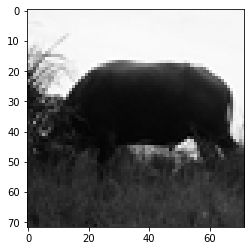

In [9]:
plt.figure()
print(data[0].shape)
plt.imshow(data[0], cmap="gray")

In [31]:
data_flattened =  flatten_images(data)

pca_stl10 = PCA(data_flattened)

pca_stl10.normalize()

pca_stl10.get_projection_matrix()

pca_stl10.save_projection_matrix('projection_matrix')

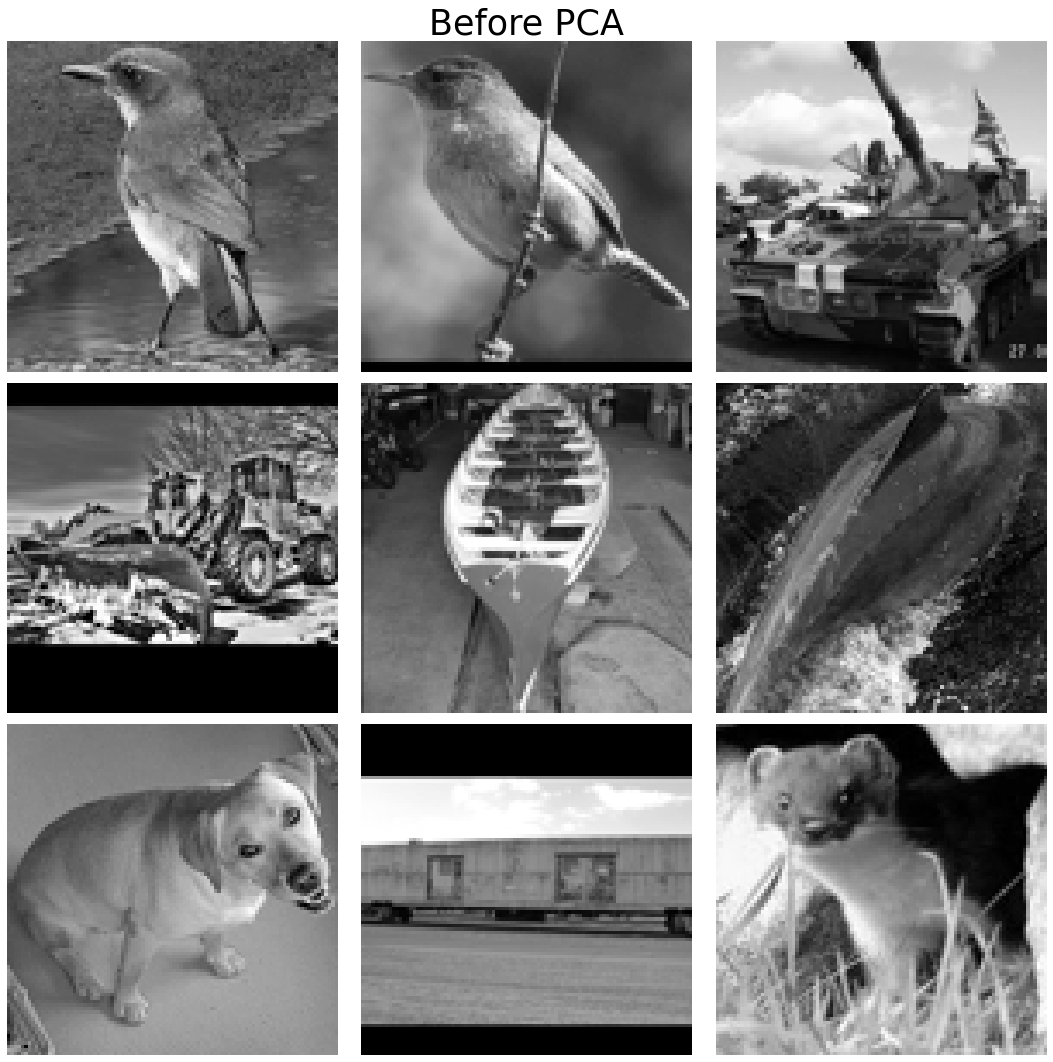

In [8]:
plot_sample(data, list(range(9)), 'Before PCA')

## References

<a id='1'>[\[1\] M. P. Deisenroth, A. A. Faisal, and C. S. Ong, Mathematics for Machine Learning. Cambridge, United Kingdom: Cambridge University Press, 2020.](https://mml-book.com)</a>  
<a id='2'>[\[2\] Pearson, K. 1901. On lines and planes of closest fit to systems of points in space. Philosophical Magazine 2:559-572](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1056/2012/10/pearson1901.pdf)</a>  
<a id='3'>[\[3\] A. Coates, A. Ng, en H. Lee, “An Analysis of Single Layer Networks in Unsupervised Feature Learning”, in AISTATS, 2011.](https://cs.stanford.edu/~acoates/stl10/)</a>  
